[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [3]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"   #,1"

Sat Oct 25 03:23:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:43:00.0 Off |                  N/A |
| 80%   56C    P3            123W /  350W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [5]:
#!pip install -q peft bitsandbytes transformers==4.47.0 tf-keras
!rsync -a --progress /data/lmbraid19/argusm/datasets/indoorCVPR_09.tar /tmp/ && mkdir -p /tmp/indoorCVPR && tar -xf /tmp/indoorCVPR_09.tar -C /tmp/indoorCVPR
!rsync -a --progress /work/dlclarge2/zhangj-zhangj-CFM/data/training2 /tmp/
!file /tmp/indoorCVPR
!file /tmp/training2

sending incremental file list
sending incremental file list
/tmp/indoorCVPR: directory
/tmp/training2: directory


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [6]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from cvla.data_loader_h5 import H5Dataset
from cvla.data_loader_jsonl import JSONLDataset
from cvla.data_augmentations import augment_image_rgb, RandomizeBackgrounds
from cvla.data_augmentations import complexify_text, DepthAugmentation
from cvla.data_loader_images import ImageFolderDataset
from torchvision import transforms
from torch.utils.data import random_split
import torch
import random

model_location = Path("/data/lmbraid19/argusm/models")
dataset_location = Path("/tmp/training2")

bg_image_dataset = ImageFolderDataset("/tmp/indoorCVPR/Images", transform=transforms.RandomResizedCrop((448,448)))
randomize_background = RandomizeBackgrounds(p=0.2, background_images=bg_image_dataset)
augment_depth = DepthAugmentation(depth_range=(25, 100), max_delta_depth=35)

full_dataset = H5Dataset(
    dataset_location,
    augment_rgb=augment_image_rgb,
    augment_text=complexify_text,
    augment_depth=augment_depth,
    return_depth=False,
    action_encoder="xyzrotvec-cam-512xy",
)

# 手动定义验证集大小
val_size = 1000  # 固定1000条
train_size = len(full_dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

val_indices_small = random.sample(range(len(val_dataset)), 200)
val_dataset_small = torch.utils.data.Subset(val_dataset, val_indices_small)

print(f"Total samples: {len(full_dataset)} | Train: {len(train_dataset)} | Val: {len(val_dataset)}| Smallv:{len(val_dataset_small)}")


'''
train_dataset = H5Dataset(dataset_location, augment_rgb=augment_image_rgb, augment_text=complexify_text,
                          augment_depth=augment_depth, return_depth=True,action_encoder="xyzrotvec-cam-512xy")
#, augment_rgbds=randomize_background

print("dataset_location:", dataset_location,"samples:", len(train_dataset))
'''

/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/sapien/_vulkan_tricks.py:37: UserWarning: Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.
  warn("Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.")


Total samples: 88244 | Train: 87244 | Val: 1000| Smallv:200


'\ntrain_dataset = H5Dataset(dataset_location, augment_rgb=augment_image_rgb, augment_text=complexify_text,\n                          augment_depth=augment_depth, return_depth=True,action_encoder="xyzrotvec-cam-512xy")\n#, augment_rgbds=randomize_background\n\nprint("dataset_location:", dataset_location,"samples:", len(train_dataset))\n'

### Set up and test data loaders


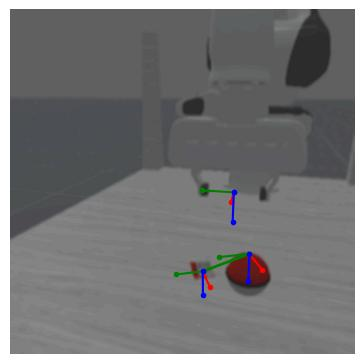
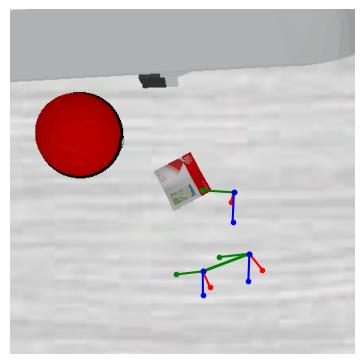
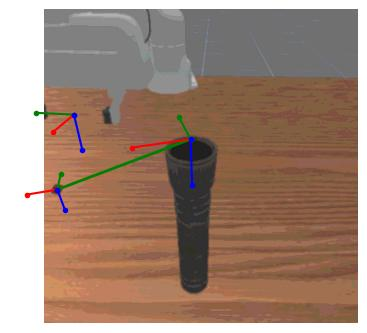
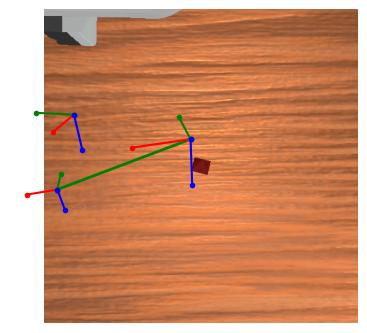
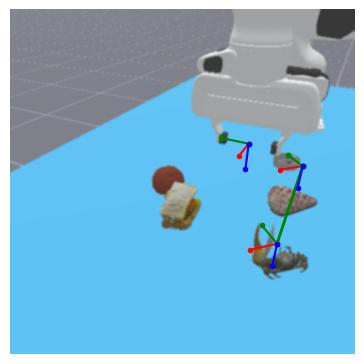
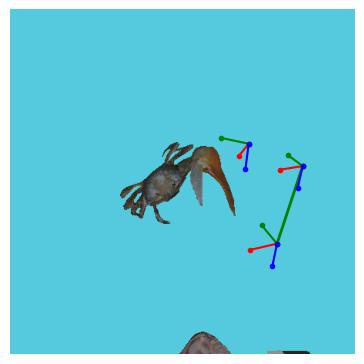
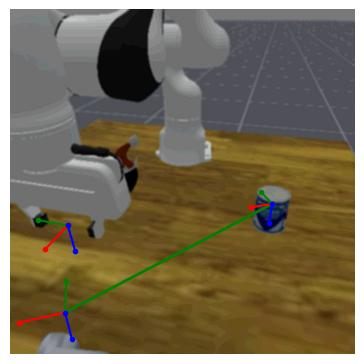
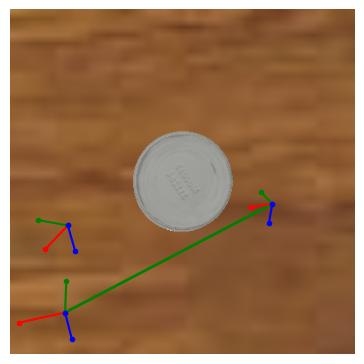
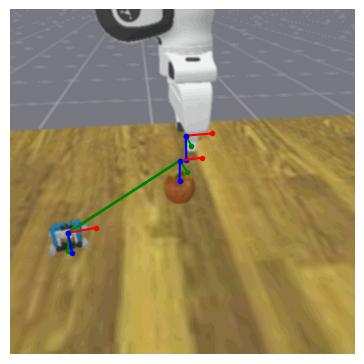
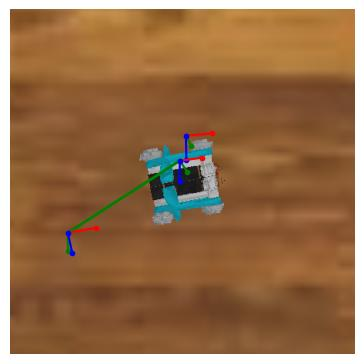
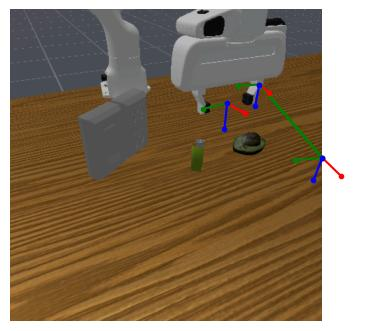
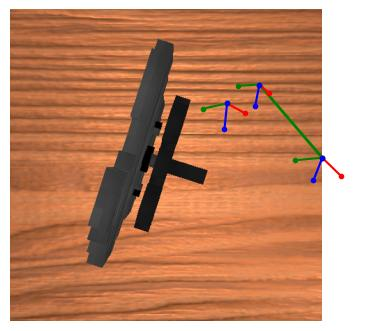

In [7]:
from cvla.utils_vis import render_example
import matplotlib.pyplot as plt
from cvla.utils_traj_tokens import getActionEncInstance

enc = getActionEncInstance("xyzrotvec-cam-512xy")
num_samples = 3*2
html_imgs = ""
for i in range(num_samples):
    image, sample = train_dataset[i]
    prefix = sample["prefix"]
    html_imgs += render_example(image[0], label=sample["suffix"], enc=enc, text=prefix, camera=sample["camera"])
    html_imgs += render_example(image[1], label=sample["suffix"], enc=enc, text=prefix, camera=sample["camera"])

plot_images = True
if plot_images:
    from IPython.display import display, HTML
    display(HTML(html_imgs))
    

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [8]:
# from huggingface_hub import notebook_login
# notebook_login()

In [9]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import torch
import transformers

#transformers.utils.logging.set_verbosity_error()

# setting device on GPU if available, else CPU
print("cuda visible devices:", os.environ["CUDA_VISIBLE_DEVICES"])
devices_good = sorted((int(x) for x in os.environ["CUDA_VISIBLE_DEVICES"].split(",")))
DEVICE = torch.device('cuda')
print(DEVICE)
print('Using device:', DEVICE)
print("Good devices", devices_good)

TORCH_DTYPE = torch.bfloat16
# use checkpoint
#LOCAL_CHECKPOINT = "/data/lmbraid19/argusm/models/_text_lr3e-05xyzrotvec-cam-512xy256d_2025-04-23_12-03-48/checkpoint-4687"

#fine-tune directly on paligemma2
MODEL_NAME = "google/paligemma2-3b-pt-224"

processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-224")
base_model = PaliGemmaForConditionalGeneration.from_pretrained(
    "google/paligemma2-3b-pt-224",
    torch_dtype=TORCH_DTYPE,
    attn_implementation="eager"
)

#.to("cuda") 
tokenizer = processor.tokenizer


cuda visible devices: 0,1
cuda
Using device: cuda
Good devices [0, 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PaliGemma2WithRotLoss(nn.Module):
    def __init__(self, base_model, hidden_dim=2304):
        super().__init__()
        self.base = base_model
        self.hidden_dim = hidden_dim
        # 🔧 修复 HuggingFace Trainer 兼容性
        self.config = base_model.config
        self._keys_to_ignore_on_save = getattr(base_model, "_keys_to_ignore_on_save", None)

        # 简单旋转预测头
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3)   # rotvec (x, y, z)
        )

    def forward(self, inputs, rotation_labels=None, **kwargs):
        device = next(self.base.parameters()).device
        inputs = {k: v.to(device) if hasattr(v, "to") else v for k, v in inputs.items()}
    
         #  主任务 forward（单次输入两张图）
        outputs = self.base(**inputs, output_hidden_states=True)
        main_loss = getattr(outputs, "loss", None)
    
        #  提取 top-view 特征（每隔一张取一张）
        hidden_states = outputs.image_hidden_states  # [2B, hidden_dim]
        top_hidden = hidden_states[1::2].mean(dim=1)
        pred_rot = self.aux_head(top_hidden)
    
        #  计算旋转 loss
        rot_loss = torch.tensor(0.0, device=device)
        if rotation_labels is not None:
            true_rot = rotation_labels.to(device)
            rot_loss = 1 - F.cosine_similarity(pred_rot, true_rot, dim=-1).mean()
    
        #  合并 loss
        total_loss = main_loss + 0.3 * rot_loss if main_loss is not None else 0.3 * rot_loss
    
        #  包装输出（兼容 transformers Trainer）
        if not isinstance(outputs, dict):
            outputs = outputs.__dict__
    
        outputs["loss"] = total_loss
        outputs["main_loss"] = main_loss
        outputs["rot_loss"] = rot_loss
        outputs["pred_rotations"] = pred_rot
    
        return outputs


    def generate(self, *args, **kwargs):
        return self.base.generate(*args, **kwargs)

model = PaliGemma2WithRotLoss(base_model)


In [11]:
import random
def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)

In [12]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image><image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]
    images_flat = [img for img_list_x in images for img in img_list_x]
    inputs = processor(
        text=prefixes,
        images=images_flat,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE)
    return inputs

def collate_fn_dualview(batch):
    images, labels = zip(*batch)

    prefixes = ["<image><image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    # 扁平化： [side1, top1, side2, top2, ...]
    images_flat = [img for img_pair in images for img in img_pair]

    inputs = processor(
        text=prefixes,
        images=images_flat,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    )

    # 转换 dtype（但不放 device）
    inputs = {k: v.to(TORCH_DTYPE) if torch.is_floating_point(v) else v for k, v in inputs.items()}

    batch_out = {"inputs": inputs}

    if "rotation_labels" in labels[0]:
        batch_out["rotation_labels"] = torch.stack(
            [label["rotation_labels"] for label in labels]
        )

    return batch_out

batch = [train_dataset[i] for i in range(3)]
inputs = collate_fn(batch)
for x in inputs:
    print(x, inputs[x].shape)

input_ids torch.Size([3, 545])
token_type_ids torch.Size([3, 545])
attention_mask torch.Size([3, 545])
pixel_values torch.Size([6, 3, 224, 224])
labels torch.Size([3, 545])


In [13]:
inputs["input_ids"]

tensor([[257152, 257152, 257152,  ..., 257106, 257111,      1],
        [257152, 257152, 257152,  ..., 257115, 257139,      1],
        [     0, 257152, 257152,  ..., 257116, 257138,      1]])

In [14]:
from cvla.utils_eval import Evaluator
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from math import ceil



TRAIN_EXAMPLES = len(train_dataset)
BATCH_SIZE = 32
BATCH_SIZE_DEV = 2
GRAD_ACCUM = int(round(BATCH_SIZE / BATCH_SIZE_DEV))
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
SEQLEN = 12
#EVAL_STEPS = 200
EVAL_STEPS = 200
SAVE_LIMIT = 5
LOGGING_STEPS = 10


run_name = "_topview_70000_basetop_two"
new_model_location = Path("/work/dlclarge2/zhangj-zhangj-CFM/models")
save_path = new_model_location / (str(Path(dataset_location).stem) + run_name)
print("save_path", save_path)
print("TRAIN_STEPS",TRAIN_STEPS)
print("GRAD_ACCUM", GRAD_ACCUM)

writer = SummaryWriter(log_dir=str(save_path / "tb_logs"))

import torch
from tqdm import tqdm
from math import ceil
import torch.nn.functional as F

# ============================================================
# 🔧 递归 move_to_device 工具函数
# ============================================================
def move_to_device(obj, device):
    """Recursively move nested tensors or dicts/lists to the target device."""
    if isinstance(obj, torch.Tensor):
        return obj.to(device)
    elif isinstance(obj, dict):
        return {k: move_to_device(v, device) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [move_to_device(x, device) for x in obj]
    else:
        return obj


# ============================================================
# 🧠 Rotation-Aware Trainer
# ============================================================
class RotationAwareCustomTrainer(Seq2SeqTrainer):
    """
    Trainer that:
      - uses LM loss + λ * rotation loss for training
      - runs model.generate() for evaluation
      - computes both textual & spatial metrics via Evaluator
    """

    def __init__(self, lambda_rot=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_rot = lambda_rot

    # ============================
    #        TRAINING PHASE
    # ============================
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Combined LM loss + rotation loss
        """
        device = next(model.parameters()).device
        inputs = move_to_device(inputs, device)  # ✅ 确保所有张量都在同一设备上

        outputs = model(**inputs)
        main_loss = getattr(outputs, "loss", None)

        if main_loss is None:
            raise ValueError("Model outputs do not contain 'loss' field.")

        rot_loss = torch.tensor(0.0, device=main_loss.device)
        if "rotation_labels" in inputs and "pred_rotations" in outputs:
            pred_rot = outputs["pred_rotations"]
            true_rot = inputs["rotation_labels"].to(pred_rot.device)
            #rot_loss = F.l1_loss(pred_rot, true_rot)
            rot_loss = 1 - F.cosine_similarity(pred_rot, true_rot, dim=-1).mean()
            total_loss = main_loss + self.lambda_rot * rot_loss
        else:
            total_loss = main_loss

        # Logging
        if self.state.global_step % self.args.logging_steps == 0:
            writer.add_scalar("train/loss_total", total_loss.item(), self.state.global_step)
            writer.add_scalar("train/loss_main", main_loss.item(), self.state.global_step)
            writer.add_scalar("train/loss_rot", rot_loss.item(), self.state.global_step)
            writer.add_scalar("train/lr", self.optimizer.param_groups[0]["lr"], self.state.global_step)

        return (total_loss, outputs) if return_outputs else total_loss

    # ============================
    #        EVALUATION PHASE
    # ============================
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """
        Overridden evaluation:
          - Generates text predictions
          - Evaluates with Evaluator (trajectory metrics)
          - Logs to TensorBoard
        """
        self.model.eval()
        dataset = eval_dataset or self.eval_dataset
        device = next(self.model.parameters()).device

        # unwrap dataset (for H5Dataset)
        def unwrap_dataset(dset):
            while hasattr(dset, "dataset"):
                dset = dset.dataset
            return dset

        base_dataset = unwrap_dataset(dataset)
        camera = dataset[0][1]["camera"]

        evaluator = Evaluator(
            getActionEncInstance("xyzrotvec-cam-512xy"),
            camera_fixed=camera,
            encoder_labels=base_dataset.action_encoder,
        )

        eval_batch_size = self.args.per_device_eval_batch_size
        test_samples = min(len(dataset), 200)

        for start_idx in tqdm(
            range(0, test_samples, eval_batch_size),
            total=ceil(test_samples / eval_batch_size),
        ):
            batch_idx = range(start_idx, min(start_idx + eval_batch_size, test_samples))
            batch = [dataset[i] for i in batch_idx]

            # ✅ 用 collate_fn 组 batch
            inputs = collate_fn_dualview(batch)
            inputs = move_to_device(inputs, device)  # ✅ 自动迁移到 GPU

            model_inputs = inputs["inputs"]
            rotation_labels = inputs.get("rotation_labels", None)

            prefix_length = model_inputs["input_ids"].shape[-1]
            labels = model_inputs.get("labels", None)

            with torch.inference_mode():
                generation = self.model.generate(
                    **model_inputs,
                    max_new_tokens=13,
                    do_sample=False,
                    use_cache=False,
                )

                decoded = [
                    self.processing_class.decode(x[prefix_length:], skip_special_tokens=True)
                    for x in generation
                ]

                decoded_labels = []
                if labels is not None:
                    decoded_labels = [
                        self.processing_class.decode(
                            [t for t in x.tolist() if t >= 0],
                            skip_special_tokens=True,
                        )
                        for x in labels
                    ]

            # Evaluate trajectories
            for pred, label in zip(decoded, decoded_labels):
                evaluator.evaluate(pred, label, camera=camera)

        # Compute metrics
        stats = evaluator.report_stats()
        metrics = {f"{metric_key_prefix}_{k}": v for k, v in stats.items()}

        # Log to TensorBoard
        for k, v in metrics.items():
            writer.add_scalar(k, v, self.state.global_step)

        self.log(metrics)
        return metrics

'''
class CustomTrainer(Seq2SeqTrainer):
    """
    Trainer that:
      - uses normal loss for training
      - runs model.generate() for evaluation
      - uses Evaluator to compute real-world metrics
    """

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    
        outputs = model(**inputs)
        loss = getattr(outputs, "loss", None)
        if loss is None:
            raise ValueError("Model outputs do not contain a 'loss' field.")

        if self.state.global_step % self.args.logging_steps == 0:
            writer.add_scalar("train/loss_total", loss.item(), self.state.global_step)
            writer.add_scalar("train/lr", self.optimizer.param_groups[0]["lr"], self.state.global_step)

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """
        Overridden evaluation that generates predictions textually
        and computes spatial metrics via Evaluator.
        """
        self.model.eval()
        dataset = eval_dataset or self.eval_dataset
        # helper: unwrap nested Subsets to access H5Dataset
        def unwrap_dataset(dset):
            while hasattr(dset, "dataset"):
                dset = dset.dataset
            return dset

        base_dataset = unwrap_dataset(dataset)
        camera = dataset[0][1]["camera"]

        evaluator = Evaluator(
            getActionEncInstance("xyzrotvec-cam-512xy"),
            camera_fixed=camera,
            encoder_labels=base_dataset.action_encoder,  # ✅ now always valid
        )
        # sample limited subset for speed
        eval_batch_size = self.args.per_device_eval_batch_size
        test_samples = min(len(dataset), 200)
        device = next(self.model.parameters()).device
        
        for start_idx in tqdm(range(0, test_samples, eval_batch_size), total=ceil(test_samples / eval_batch_size)):
            batch_i = range(start_idx, min(start_idx + eval_batch_size, test_samples))
            batch = [dataset[i] for i in batch_i]
            inputs = self.data_collator(batch)
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
            prefix_length = inputs["input_ids"].shape[-1]

            with torch.inference_mode():
                generation = self.model.generate(**inputs, max_new_tokens=13, do_sample=False, use_cache=False)
                decoded = [
                    self.processing_class.decode(x[prefix_length:], skip_special_tokens=True) for x in generation
                ]
                decoded_labels = [
                    self.processing_class.decode([t for t in x.tolist() if t >= 0], skip_special_tokens=True)
                    for x in inputs["labels"]
                ]


            for pred, label in zip(decoded, decoded_labels):
                evaluator.evaluate(pred, label, camera=camera)

        stats = evaluator.report_stats()
        metrics = {f"{metric_key_prefix}_{k}": v for k, v in stats.items()}

        # log to TensorBoard
        for k, v in metrics.items():
            writer.add_scalar(k, v, self.state.global_step)

        self.log(metrics)
        return metrics
'''

save_path /work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_basetop_two
TRAIN_STEPS 2726
GRAD_ACCUM 16


'\nclass CustomTrainer(Seq2SeqTrainer):\n    """\n    Trainer that:\n      - uses normal loss for training\n      - runs model.generate() for evaluation\n      - uses Evaluator to compute real-world metrics\n    """\n\n    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):\n\n        outputs = model(**inputs)\n        loss = getattr(outputs, "loss", None)\n        if loss is None:\n            raise ValueError("Model outputs do not contain a \'loss\' field.")\n\n        if self.state.global_step % self.args.logging_steps == 0:\n            writer.add_scalar("train/loss_total", loss.item(), self.state.global_step)\n            writer.add_scalar("train/lr", self.optimizer.param_groups[0]["lr"], self.state.global_step)\n\n        return (loss, outputs) if return_outputs else loss\n\n    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):\n        """\n        Overridden evaluation that generates predictions textually\n     

## Fine-tune with JAX settings

In [15]:

for param in model.base.vision_tower.parameters():
    param.requires_grad = False

for param in model.base.multi_modal_projector.parameters():
    param.requires_grad = False
    
for name, param in model.base.named_parameters():
    if param.requires_grad == True:
        if "self_attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
            
for param in model.aux_head.parameters():
    param.requires_grad = True

args_jax = Seq2SeqTrainingArguments(
    max_steps=TRAIN_STEPS,
    per_device_train_batch_size=BATCH_SIZE_DEV,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    generation_max_length=SEQLEN,
    logging_steps=LOGGING_STEPS,
    optim="adafactor",
    evaluation_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=EVAL_STEPS,
    save_total_limit=SAVE_LIMIT,
    load_best_model_at_end=True,
    metric_for_best_model="cart_l1",
    greater_is_better=False,
    bf16=True,
    output_dir=save_path,
    report_to=["tensorboard"],
    dataloader_num_workers=4,
    remove_unused_columns=False,
)


trainer = RotationAwareCustomTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset_small,
    data_collator=collate_fn_dualview,
    args=args_jax
)

'''
trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset_small,
    data_collator=collate_fn,  # replace with your collate_fn if you use one
    args=args_jax,
)
'''

/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_114419/2211535268.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `RotationAwareCustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


'\ntrainer = CustomTrainer(\n    model=model,\n    tokenizer=tokenizer,\n    train_dataset=train_dataset,\n    eval_dataset=val_dataset_small,\n    data_collator=collate_fn,  # replace with your collate_fn if you use one\n    args=args_jax,\n)\n'

In [16]:
#only when recover from last time training
'''
trainer.args.save_safetensors = False
last_checkpoint = "/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_basetop/checkpoint-200"
trainer.train(resume_from_checkpoint=last_checkpoint)
trainer.save_model(str(save_path / "final_checkpoint"))
writer.close()
print("✅ Training completed successfully with Evaluator-based validation.")
'''

'\ntrainer.args.save_safetensors = False\nlast_checkpoint = "/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_basetop/checkpoint-200"\ntrainer.train(resume_from_checkpoint=last_checkpoint)\ntrainer.save_model(str(save_path / "final_checkpoint"))\nwriter.close()\nprint("✅ Training completed successfully with Evaluator-based validation.")\n'

In [ ]:
trainer.args.save_safetensors = False
trainer.train()
trainer.save_model(str(save_path / "final_checkpoint"))
writer.close()
print("✅ Training completed successfully with Evaluator-based validation.")

Step,Training Loss,Validation Loss


  0%|                                                                                        | 0/25 [00:00<?, ?it/s]--- Logging error ---
Traceback (most recent call last):
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/logging/__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_

In [17]:
import torch

# ✅ 取前 2 条样本组成小 batch
sample_batch = [train_dataset[i] for i in range(2)]
# 用 collate_fn 打包
inputs = collate_fn(sample_batch)

# ✅ 把张量转到 GPU 或 CPU
device = next(model.parameters()).device
inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}

# ✅ 前向传播
with torch.no_grad():
    outputs = model(**inputs)

# ✅ 打印输出结构
print("\n===== MODEL OUTPUT STRUCTURE =====")
print("Type:", type(outputs))
try:
    print("Keys:", outputs.keys())
except:
    print(dir(outputs))

# 如果是字典或 ModelOutput 对象
if hasattr(outputs, "items"):
    for k, v in outputs.items():
        print(f"{k}: {type(v)} {getattr(v, 'shape', '')}")

print("==================================\n")



===== MODEL OUTPUT STRUCTURE =====
Type: <class 'transformers.models.paligemma.modeling_paligemma.PaliGemmaCausalLMOutputWithPast'>
Keys: odict_keys(['loss', 'logits', 'image_hidden_states'])
loss: <class 'torch.Tensor'> torch.Size([])
logits: <class 'torch.Tensor'> torch.Size([2, 545, 257216])
image_hidden_states: <class 'torch.Tensor'> torch.Size([4, 256, 2304])



In [ ]:
for key, value in inputs.items():
    if torch.is_tensor(value):
        inputs[key] = value.to(DEVICE)

In [ ]:
print("Model device:", next(model.parameters()).device)
for k, v in inputs.items():
    if torch.is_tensor(v):
        print(f"  {k}: {v.device}")


In [ ]:
print(next(model.parameters()).device)
print({k: v.device for k, v in inputs.items() if torch.is_tensor(v)})